In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
bps = pd.read_csv('./simdata_all_bps_comparison.csv', header=None)

In [3]:
bps.columns = ['idx','log_sp','stdev']

In [4]:
bps.head()

,idx,log_sp,stdev
0,572,2.780960,0.265163
1,610,2.659350,0.214473
2,852,1.461990,0.160761
3,887,1.138650,0.143270
4,963,0.950547,0.126712


In [5]:
bps.shape

(138, 3)

In [6]:
bps.index = bps['idx']

In [7]:
n_bins = 1000
all_bins = range(0,n_bins)

In [8]:
all_bins_df = pd.DataFrame(index=all_bins)
all_bins_df['idx'] = all_bins_df.index
all_bins_df['log_sp'] = None
all_bins_df['stdev'] = None

In [9]:
all_bins_df.head()

,idx,log_sp,stdev
0,0,None,None
1,1,None,None
2,2,None,None
3,3,None,None
4,4,None,None


## There are 2 negative log_sp values! See to it!

In [10]:
bps.shape

(138, 3)

In [11]:
ground_truth = pd.read_csv('./10nodes_40regions_10000reads_sim_tiny2_effective_regions.txt',header=None)
ground_truth = ground_truth[0].values.tolist()
ground_truth

[277, 415, 548, 572, 635, 650, 795, 852, 963]

In [12]:
Counter((0.1*bps['log_sp'] - bps['stdev']).values > 0)

Counter({False: 119, True: 19})

In [13]:
Counter((9.1*bps['log_sp'] - bps['stdev']).values > 0)

Counter({False: 6, True: 132})

### ROC curve
Each breakpoint candidate has a different stdev value. The ROC computations should take that into account.

In [14]:
threshold_coeffs = np.linspace(0.1,15.1,1000)

In [15]:
tpr_values = []
fpr_values = []
for thr in threshold_coeffs:
    positives = bps[(thr*(bps['log_sp']) - bps['stdev'] > 0)]['idx'].values.tolist()
    negatives = bps[(thr*(bps['log_sp']) - bps['stdev'] <= 0)]['idx'].values.tolist()

    true_positives = [i for i in positives if i in ground_truth]
    false_positives = [i for i in positives if i not in true_positives]

    true_negatives = [i for i in negatives if i not in ground_truth]
    false_negatives = [i for i in negatives if i in ground_truth]

    tpr = len(true_positives) / (len(true_positives) + len(false_negatives))
    fpr = len(false_positives) / (len(false_positives) + len(true_negatives))
    tpr_values.append(tpr)
    fpr_values.append(fpr)

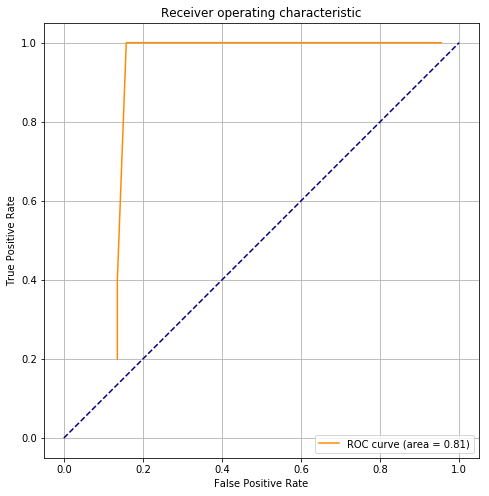

In [16]:
roc_auc = auc(fpr_values, tpr_values)
plt.figure(figsize=(8,8))
plt.plot(fpr_values, tpr_values, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()